In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
train_image_path = glob.glob('./dc/dc_2000/train/*/*.jpg')

In [3]:
len(train_image_path)

2000

In [4]:
train_image_path[:5]

['./dc/dc_2000/train\\cat\\cat.0.jpg',
 './dc/dc_2000/train\\cat\\cat.1.jpg',
 './dc/dc_2000/train\\cat\\cat.10.jpg',
 './dc/dc_2000/train\\cat\\cat.100.jpg',
 './dc/dc_2000/train\\cat\\cat.101.jpg']

In [5]:
train_image_path[-5:]

['./dc/dc_2000/train\\dog\\dog.995.jpg',
 './dc/dc_2000/train\\dog\\dog.996.jpg',
 './dc/dc_2000/train\\dog\\dog.997.jpg',
 './dc/dc_2000/train\\dog\\dog.998.jpg',
 './dc/dc_2000/train\\dog\\dog.999.jpg']

In [6]:
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [7]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [8]:
def load_preprosess_imge(path, label):
    image = tf.io.read_file(path) #加载图片
    image = tf.image.decode_jpeg(image, channels=3) #解码
    
    image = tf.image.resize(image, (360,360)) #统一定义图片大小360*360
    image = tf.image.random_crop(image, [256,256,3]) #随机裁剪出256*256的图片
    image = tf.image.random_flip_left_right(image) #随机地左右翻转
    image = tf.image.random_flip_up_down(image) #随机地上下翻转
    image = tf.image.random_brightness(image, 0.5) #图片亮度 这里最大为50%
    image = tf.image.random_contrast(image, 0,1) #对比度
    
    image = tf.cast(image, tf.float32) #转换数据类型
    image = image/255 #默认uint8范围是0-255
    label = tf.reshape(label, [1]) #[1, 2, 3] ->[[1], [2], [3]]
    return image, label

In [9]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #依据计算机CPU的个数自动使用CPU运算

In [11]:
train_image_ds = train_image_ds.map(load_preprosess_imge, num_parallel_calls=AUTOTUNE)

In [12]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

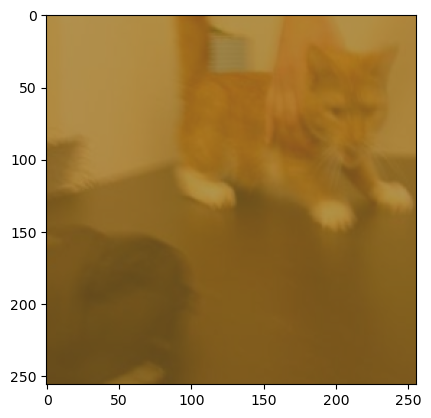

In [13]:
for img,label in train_image_ds.take(1):
    plt.imshow(img)

In [14]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [15]:
train_image_ds = train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE) #后台进行预处理

In [18]:
#9.7 建立test数据 
test_image_path = glob.glob('./dc/dc_2000/train/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_imge, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE) #test数据没必要shuffle
test_image_ds = test_image_ds.prefetch(AUTOTUNE) #后台进行预处理

In [19]:
imgs, labels = next(iter(train_image_ds))

In [20]:
imgs.shape

TensorShape([32, 256, 256, 3])

In [21]:
labels.shape

TensorShape([32, 1])

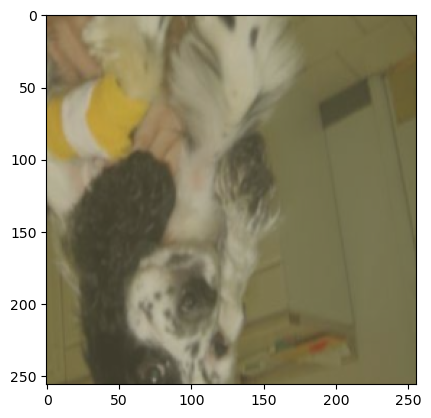

In [22]:
plt.imshow(imgs[0])

In [23]:
labels[0]

<tf.Tensor: id=254, shape=(1,), dtype=int32, numpy=array([0])>

In [24]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256,256,3), activation='relu'),
    tf.keras.layers.BatchNormalization(), #在每个卷积层后添加
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(2048, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(2048, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1), #sigmoid是0-0.5与0.5-1，这里我们只需要判断是否大于0即可，故不需要sigmoid激活函数
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 256)     147712    
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 256)     1

In [26]:
pred = model(imgs)

ResourceExhaustedError: OOM when allocating tensor with shape[32,64,252,252] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [ ]:
np.array([p[0].numpy() for p in tf.cast(pred > 0, tf.int32)])

In [ ]:
np.array([l[0].numpy() for l in labels])

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred) #from_logits参数是魔性最后没有激活 这是计算每一步的损失值
    grads = t.gradient(loss_step, model.trainable_variables) #计算损失值与可训练参数之间的梯度
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) #优化
    epoch_loss_avg(loss_step)
    train_accuracy(labels, tf.cast(pred>0,tf.int32))

In [ ]:
#9.7 
def test_step(model, images, labels):
    pred = model.predict(images) #不需要训练，用测试数据进行预测
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred) #from_logits参数是魔性最后没有激活 这是计算每一步的损失值
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0,tf.int32))

In [ ]:
train_loss_results = []
train_acc_result = []

test_loss_results = []
test_acc_result = []

In [ ]:
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    for imgs_,labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.',end='') #每训练一个BATCH输出.不换行
    print() #每训练一个epoch换行
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_result.append(train_accuracy.result())
    
    for imgs_,labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_result.append(test_accuracy.result())
    
    print('Epoch:{}:loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch+1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    #重置记录
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()